In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 128  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 50      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [76]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()
    
    d = 32
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    

    
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

In [77]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [78]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [79]:
import numpy as np
x=np.load('/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/non zeros masks/non zeros masks.npy')

In [80]:
"""
image2D = []
#mask2D = []
for i in range(195):
  for j in range(128):
    
    image2D.append(x[i,:,:,j])
    #mask2D.append(y[i,:,:,j])
x = np.array(image2D)
#y = np.array(mask2D)
"""

'\nimage2D = []\n#mask2D = []\nfor i in range(195):\n  for j in range(128):\n    \n    image2D.append(x[i,:,:,j])\n    #mask2D.append(y[i,:,:,j])\nx = np.array(image2D)\n#y = np.array(mask2D)\n'

In [81]:
np.unique(x)

array([0, 1, 2, 3], dtype=uint8)

In [82]:
x=np.where(x==0, 4, x) 

In [83]:
np.unique(x)

array([1, 2, 3, 4], dtype=uint8)

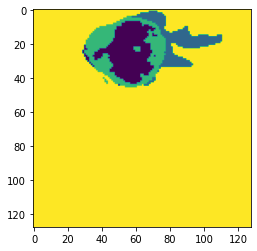

In [84]:
plt.imshow(x[25])

In [85]:
x=x/4

In [86]:
np.unique(x)

array([0.25, 0.5 , 0.75, 1.  ])

In [87]:
np.shape(x)

(13393, 128, 128)

In [88]:
x_train = np.expand_dims(x, axis = 3)

In [89]:
np.shape(x_train)

(13393, 128, 128, 1)

In [90]:
np.unique(x_train)

array([0.25, 0.5 , 0.75, 1.  ])

In [16]:
import matplotlib.pyplot as plt
def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)))    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [92]:
saved_model_gan='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/full model'
saved_model_generator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/generator'
saved_model_discrimator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/discrimantor'

Epoch: 1 	 Discriminator Loss: 0.43981844186782837 		 Generator Loss: 1.4804365634918213


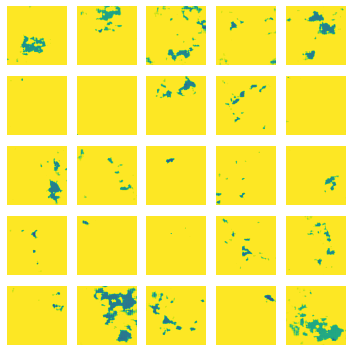

Epoch: 2 	 Discriminator Loss: 0.31262969970703125 		 Generator Loss: 2.1231324672698975


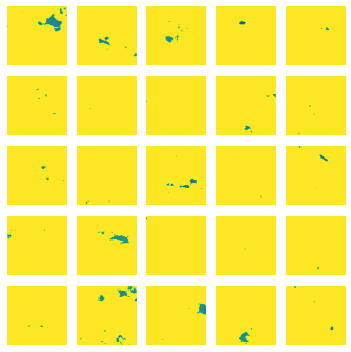

Epoch: 3 	 Discriminator Loss: 0.5042946338653564 		 Generator Loss: 1.8570594787597656


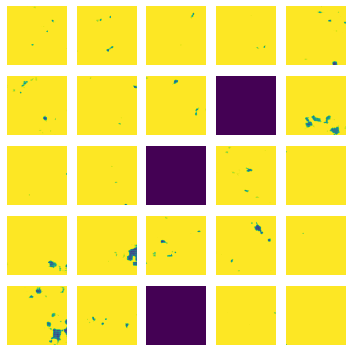

Epoch: 4 	 Discriminator Loss: 0.37418389320373535 		 Generator Loss: 2.4113030433654785


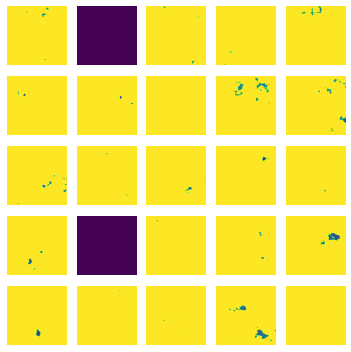

Epoch: 5 	 Discriminator Loss: 0.4341962933540344 		 Generator Loss: 1.70836341381073


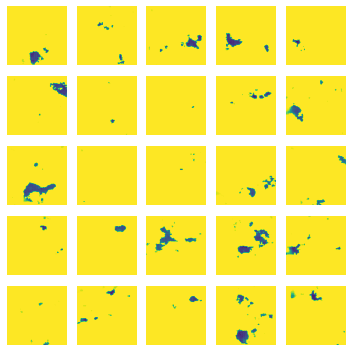

Epoch: 6 	 Discriminator Loss: 0.40009456872940063 		 Generator Loss: 1.857980489730835


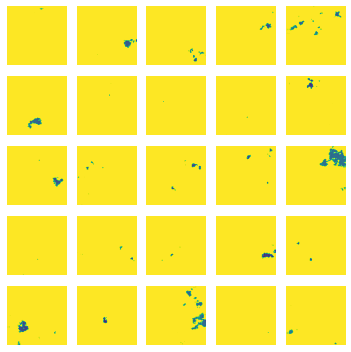

Epoch: 7 	 Discriminator Loss: 0.4145260155200958 		 Generator Loss: 2.200028896331787


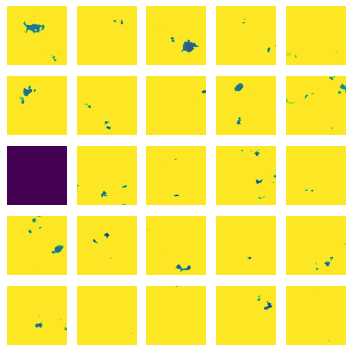

Epoch: 8 	 Discriminator Loss: 0.37415575981140137 		 Generator Loss: 2.3213696479797363


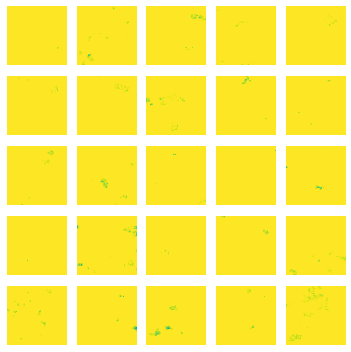

Epoch: 9 	 Discriminator Loss: 0.2595205307006836 		 Generator Loss: 2.7363433837890625


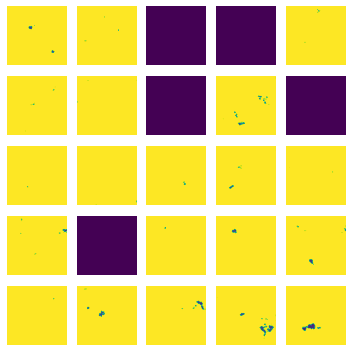

Epoch: 10 	 Discriminator Loss: 0.2506862282752991 		 Generator Loss: 2.339907169342041


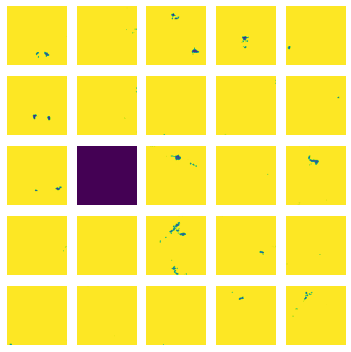

Epoch: 11 	 Discriminator Loss: 0.3265994191169739 		 Generator Loss: 2.8169431686401367


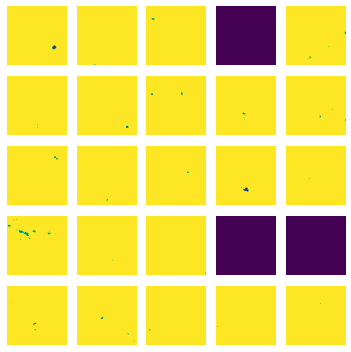

Epoch: 12 	 Discriminator Loss: 0.29229265451431274 		 Generator Loss: 2.8928656578063965


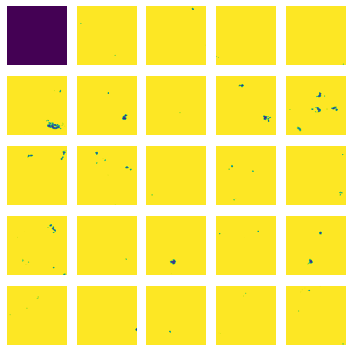

Epoch: 13 	 Discriminator Loss: 0.2227458655834198 		 Generator Loss: 3.35630464553833


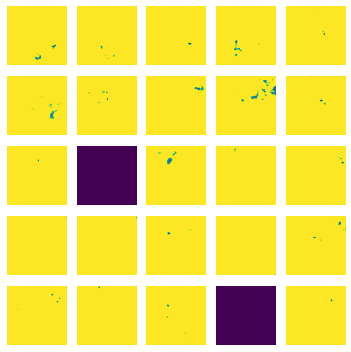

Epoch: 14 	 Discriminator Loss: 0.20554591715335846 		 Generator Loss: 3.14825701713562


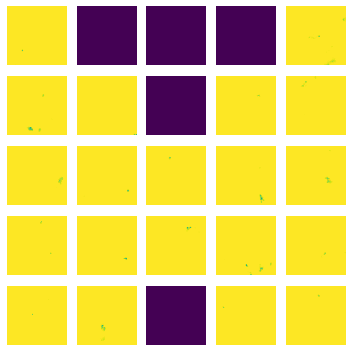

Epoch: 15 	 Discriminator Loss: 0.3349968194961548 		 Generator Loss: 2.724863290786743


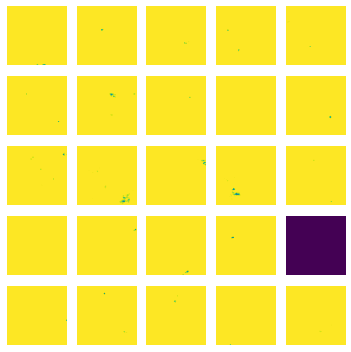

Epoch: 16 	 Discriminator Loss: 0.2206946611404419 		 Generator Loss: 3.403731346130371


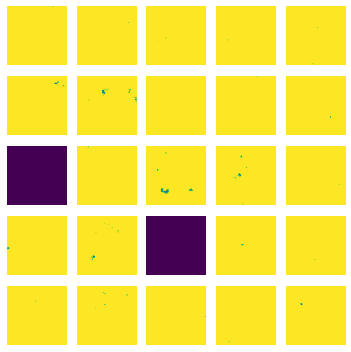

Epoch: 17 	 Discriminator Loss: 0.34888747334480286 		 Generator Loss: 3.220778226852417


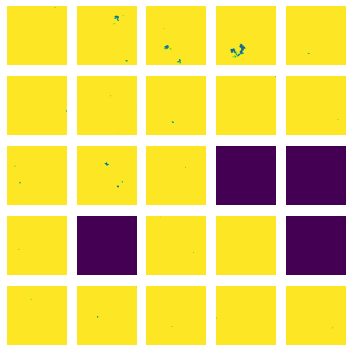

Epoch: 18 	 Discriminator Loss: 0.22694267332553864 		 Generator Loss: 3.182924270629883


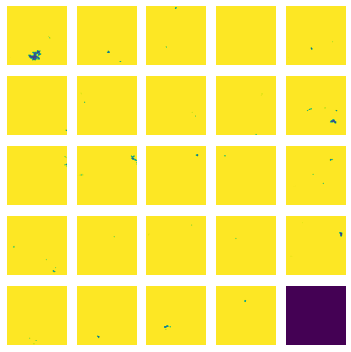

Epoch: 19 	 Discriminator Loss: 0.19328251481056213 		 Generator Loss: 3.249073028564453


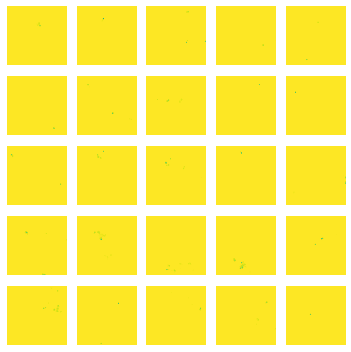

Epoch: 20 	 Discriminator Loss: 0.2079036682844162 		 Generator Loss: 3.1801047325134277


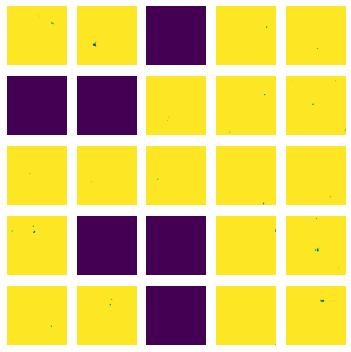

Epoch: 21 	 Discriminator Loss: 0.24333854019641876 		 Generator Loss: 2.5886318683624268


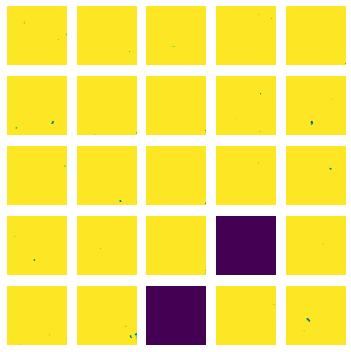

Epoch: 22 	 Discriminator Loss: 0.1937032788991928 		 Generator Loss: 3.667111873626709


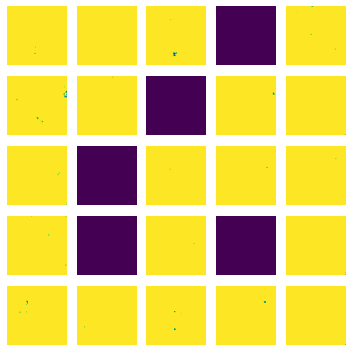

Epoch: 23 	 Discriminator Loss: 0.2740594744682312 		 Generator Loss: 2.9008331298828125


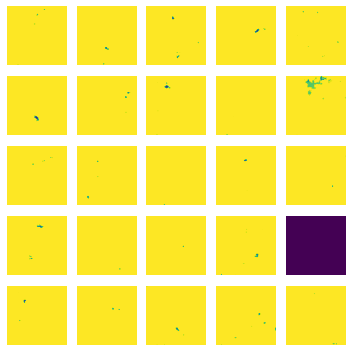

Epoch: 24 	 Discriminator Loss: 0.1967812329530716 		 Generator Loss: 3.4050204753875732


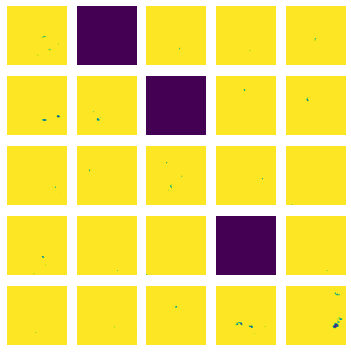

Epoch: 25 	 Discriminator Loss: 0.1916651725769043 		 Generator Loss: 3.779371976852417


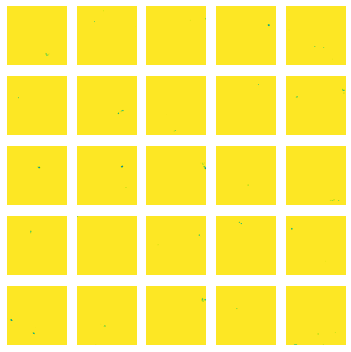

Epoch: 26 	 Discriminator Loss: 0.2754155099391937 		 Generator Loss: 3.4113454818725586


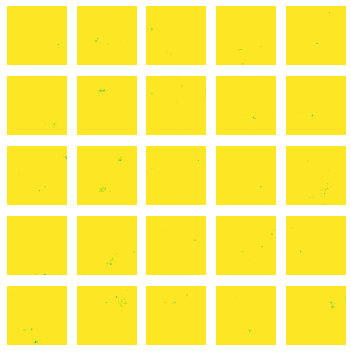

Epoch: 27 	 Discriminator Loss: 0.20132406055927277 		 Generator Loss: 3.4044246673583984


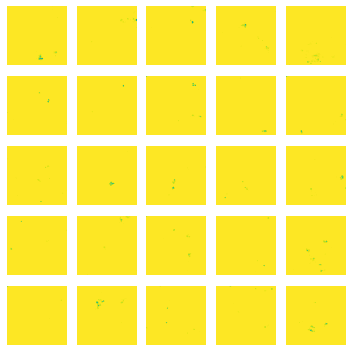

Epoch: 28 	 Discriminator Loss: 0.18750879168510437 		 Generator Loss: 4.903111934661865


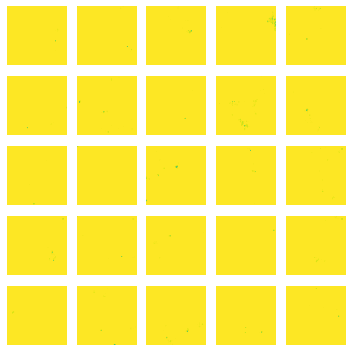

Epoch: 29 	 Discriminator Loss: 0.19473320245742798 		 Generator Loss: 4.0859246253967285


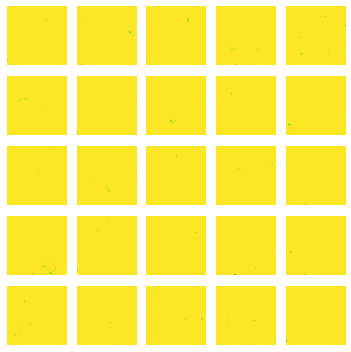

Epoch: 30 	 Discriminator Loss: 0.19767436385154724 		 Generator Loss: 4.086373805999756


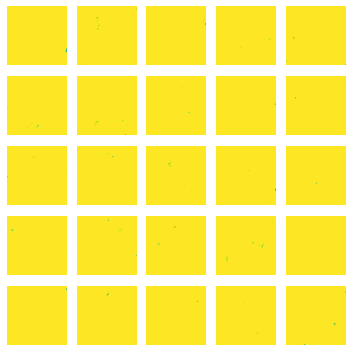

Epoch: 31 	 Discriminator Loss: 0.1907844990491867 		 Generator Loss: 3.8268117904663086


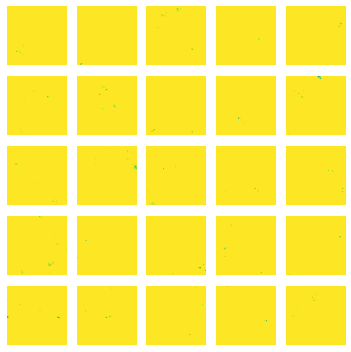

Epoch: 32 	 Discriminator Loss: 0.2065444439649582 		 Generator Loss: 3.535472869873047


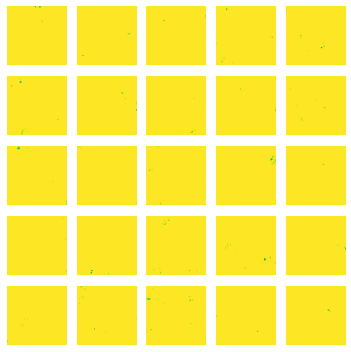

Epoch: 33 	 Discriminator Loss: 0.19805052876472473 		 Generator Loss: 3.819047689437866


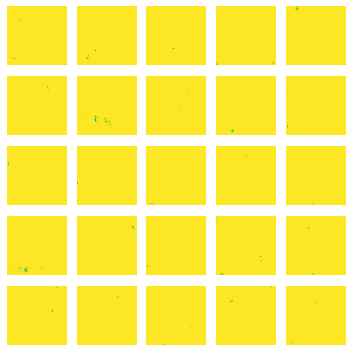

Epoch: 34 	 Discriminator Loss: 0.19016392529010773 		 Generator Loss: 4.28065299987793


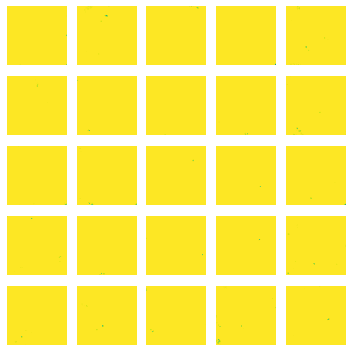

Epoch: 35 	 Discriminator Loss: 0.18991750478744507 		 Generator Loss: 4.070930480957031


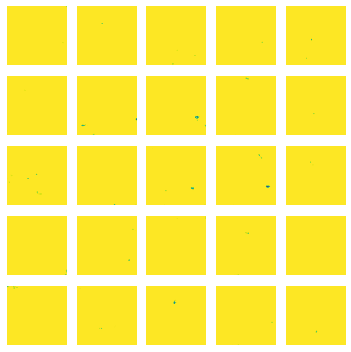

Epoch: 36 	 Discriminator Loss: 0.18118414282798767 		 Generator Loss: 4.386649131774902


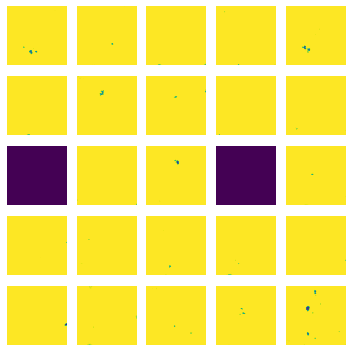

Epoch: 37 	 Discriminator Loss: 0.20933347940444946 		 Generator Loss: 3.7305712699890137


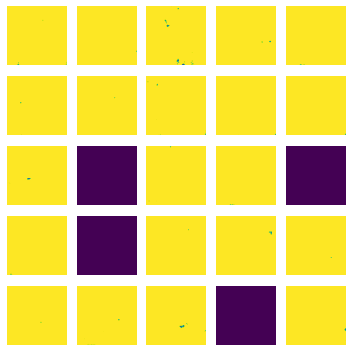

Epoch: 38 	 Discriminator Loss: 0.198147252202034 		 Generator Loss: 4.288205146789551


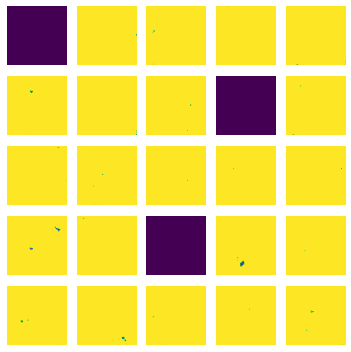

Epoch: 39 	 Discriminator Loss: 0.2220417559146881 		 Generator Loss: 3.7915947437286377


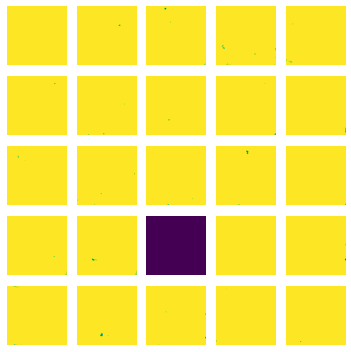

Epoch: 40 	 Discriminator Loss: 0.19684743881225586 		 Generator Loss: 4.219054698944092


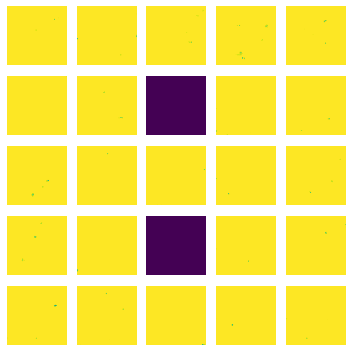

Epoch: 41 	 Discriminator Loss: 0.19606702029705048 		 Generator Loss: 3.8625030517578125


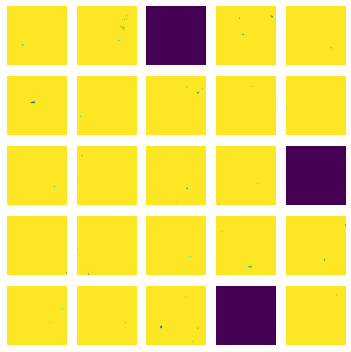

Epoch: 42 	 Discriminator Loss: 0.2510588765144348 		 Generator Loss: 3.8559155464172363


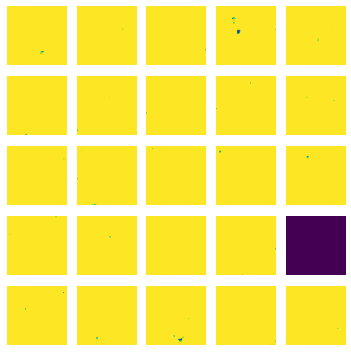

Epoch: 43 	 Discriminator Loss: 0.2189914882183075 		 Generator Loss: 3.5275588035583496


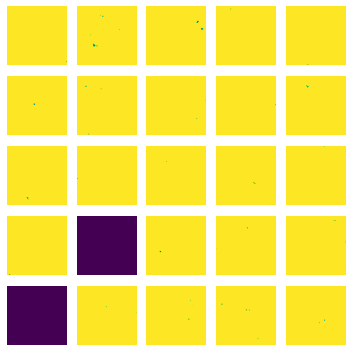

Epoch: 44 	 Discriminator Loss: 0.1881774365901947 		 Generator Loss: 4.295255184173584


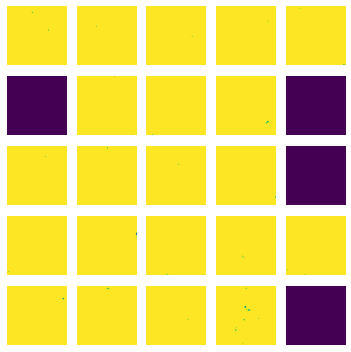

Epoch: 45 	 Discriminator Loss: 0.22121194005012512 		 Generator Loss: 3.886293411254883


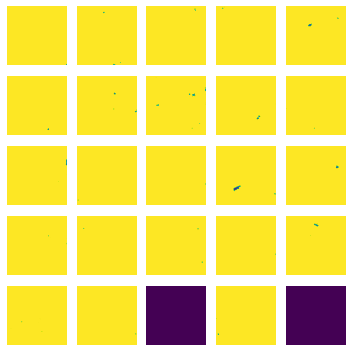

Epoch: 46 	 Discriminator Loss: 0.18184584379196167 		 Generator Loss: 4.615408897399902


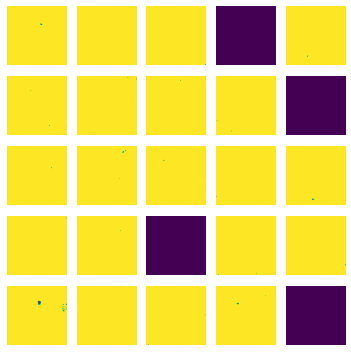

Epoch: 47 	 Discriminator Loss: 0.18531137704849243 		 Generator Loss: 4.292879581451416


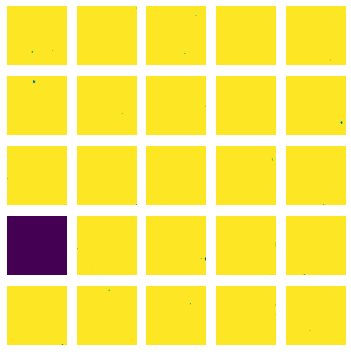

Epoch: 48 	 Discriminator Loss: 0.28252270817756653 		 Generator Loss: 3.6140213012695312


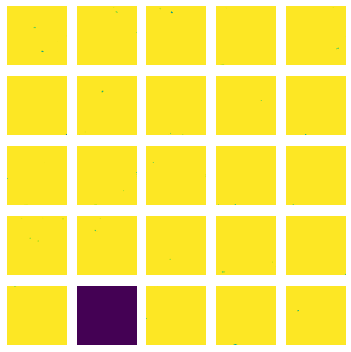

Epoch: 49 	 Discriminator Loss: 0.18079935014247894 		 Generator Loss: 4.1223320960998535


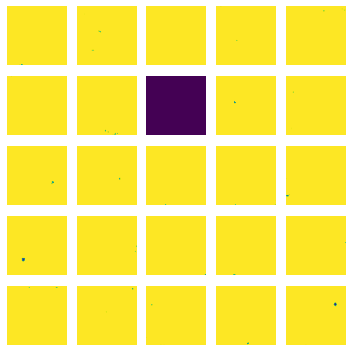

Epoch: 50 	 Discriminator Loss: 0.19058029353618622 		 Generator Loss: 4.701546669006348


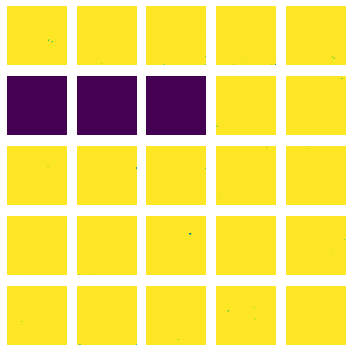

In [93]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]###check this line  and its value in the first dimensions
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

In [2]:
path_discrim='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/discrimator'
path_generator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/generator'
path_gan='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/full model'

In [95]:
generator.save(path_generator)
gan.save(path_gan)
discriminator.save(path_discrim)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/generator/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/full model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/discrimator/assets


In [3]:
from tensorflow import keras

In [5]:
model = keras.models.load_model(path_generator)

In [8]:
noise = np.random.normal(0, 1, size=(25, noise_dim))

In [10]:
generated_images = model.predict(noise)   #Create the images from the GAN.

In [11]:
generated_images.shape

(25, 128, 128, 1)

In [13]:
a=generated_images[3,:,:,0]

In [18]:
np.unique(a)

array([0.99121284, 0.99987346, 0.9999521 , 1.        ], dtype=float32)

In [20]:
generator=model

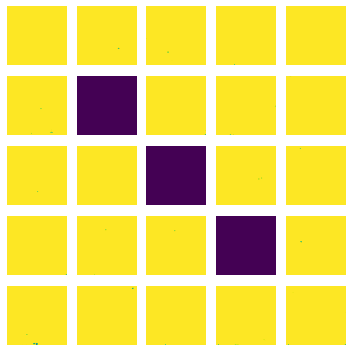

In [21]:
show_images(noise, (5, 5))

In [22]:
generated_images.shape

(25, 128, 128, 1)

In [28]:
a=generated_images[0,:,:,0]

In [24]:
a.shape

(128, 128)

In [29]:
np.unique(a)

array([0.98019457, 0.98662126, 0.99955505, 0.9997307 , 0.999965  ,
       1.        ], dtype=float32)

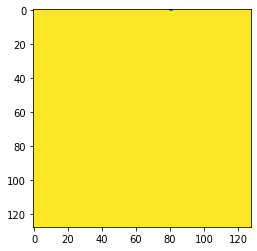

In [31]:
plt.imshow(a)

In [30]:
a

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)